## Import Libraries and Datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
#Load in the persons PUMS dataset for WA state
p_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_p53.csv")

## Choose PUMS and Preprocess

In [3]:
#Variables for testing; filter to cols and drop na vars
pums_data = p_df[['AGEP','COW','JWMNP','MAR','SCHL','SEX','PINCP']]
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

Dataset n=359075 pre-cleaning
Dataset n=152416 post-cleaning


In [4]:
#This cell removed; used sparse categorical loss to avoid OHE
#Split categorical data into OHE binary vars
cow_dummies = pd.get_dummies(pums_data['COW'], prefix='COW')
mar_dummies = pd.get_dummies(pums_data['MAR'], prefix='MAR')
sex_dummies = pd.get_dummies(pums_data['SEX'], prefix='SEX')
pums_data_numeric = pums_data[['AGEP','JWMNP','SCHL','PINCP']]
num_var_numeric = len(pums_data_numeric.columns)

#Data after encoding
model_data_df = pd.concat([pums_data_numeric, cow_dummies, mar_dummies, sex_dummies], axis=1)
model_data_df = pd.concat([pums_data_numeric, cow_dummies], axis=1)
model_data_df

,AGEP,JWMNP,SCHL,PINCP,COW_1.0,COW_2.0,COW_3.0,COW_4.0,COW_5.0,COW_6.0,COW_7.0,COW_8.0
4,52,70.0,21.0,160000.0,1,0,0,0,0,0,0,0
5,51,20.0,21.0,50000.0,0,0,1,0,0,0,0,0
7,59,30.0,19.0,26710.0,0,0,1,0,0,0,0,0
8,56,15.0,16.0,23600.0,1,0,0,0,0,0,0,0
9,40,5.0,5.0,10000.0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
359058,21,4.0,19.0,2700.0,1,0,0,0,0,0,0,0
359065,21,90.0,14.0,8200.0,1,0,0,0,0,0,0,0
359070,22,35.0,16.0,37200.0,0,0,0,0,1,0,0,0
359071,19,7.0,18.0,5300.0,1,0,0,0,0,0,0,0


In [5]:
#Standardize the input data from -1 to 1 TODO and remove outliers (>2std)
scaler = skpre.StandardScaler()
model_data = model_data_df.values
model_data[:,:num_var_numeric] = scaler.fit_transform(model_data[:,:num_var_numeric])

#Separate into train/test data
train_idx = round(len(model_data)*.9)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]
train_data

array([[ 0.63623035,  1.83970982,  0.68939993, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.56578925, -0.31801862,  0.68939993, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.12931806,  0.11352707,  0.05435252, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.98843585, -0.7495643 , -0.26317119, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.28402485, -0.53379146, -0.26317119, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00226044,  0.7608456 ,  0.05435252, ...,  0.        ,
         0.        ,  0.        ]])

## Set Model and Parameters

In [6]:
#Hyperparameters
batch_size = 64
epochs = 10
learning_rate = 0.0001
rho = 0.9
latent_dim = 4
manifest_dim = model_data.shape[1]
hidden_dim = 50

#TODO:
#Throw out outliers/verify data processing is giving good distributions
#Verify the distributions of the z variables
#Find way to test similarity of joint distributions at end
#Test speeds for sampling new people
#Disentangled VAE
#Build a GAN
#Test household/person combinations
#Test new combinations of hyperparameters

In [7]:
#A layer that takes mean/variance as inputs and returns a random sample z
class Sampling(layers.Layer):
    def call(self, inputs): #Keras method that defines the layer outputs
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(z_log_var) * epsilon

In [8]:
#Encoder
encoder_inputs = keras.Input(shape=(manifest_dim,), name="inputlayer")
x = layers.Dense(hidden_dim, activation="tanh", name="denselayer1")(encoder_inputs)
x = layers.Dense(hidden_dim, activation="tanh", name="denselayer2")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputlayer (InputLayer)         [(None, 12)]         0                                            
__________________________________________________________________________________________________
denselayer1 (Dense)             (None, 50)           650         inputlayer[0][0]                 
__________________________________________________________________________________________________
denselayer2 (Dense)             (None, 50)           2550        denselayer1[0][0]                
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 4)            204         denselayer2[0][0]                
____________________________________________________________________________________________

In [9]:
#Decoder
latent_inputs = keras.Input(shape=(latent_dim,),name="inputlayer")
x = layers.Dense(hidden_dim, activation="tanh", name="denselayer1")(latent_inputs)
x = layers.Dense(hidden_dim, activation="tanh", name="denselayer2")(x)
decoder_outputs = layers.Dense(manifest_dim, activation="linear", name="outputs")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputlayer (InputLayer)      [(None, 4)]               0         
_________________________________________________________________
denselayer1 (Dense)          (None, 50)                250       
_________________________________________________________________
denselayer2 (Dense)          (None, 50)                2550      
_________________________________________________________________
outputs (Dense)              (None, 12)                612       
Total params: 3,412
Trainable params: 3,412
Non-trainable params: 0
_________________________________________________________________


In [10]:
#Define custom loss function for combined numerical and categorical data
def get_reconstruction_loss(x, reconstruction, num_var_numeric):
    data_num = x[:,:num_var_numeric]
    data_cat = x[:,num_var_numeric:]
    reconstruction_num = reconstruction[:,:num_var_numeric]
    reconstruction_cat = reconstruction[:,num_var_numeric:]
            
    #Mean squared error for numerical variables
    reconstruction_loss_numerical = keras.losses.mean_squared_error(data_num, reconstruction_num)
    reconstruction_loss_numerical = tf.reduce_mean(reconstruction_loss_numerical)
    
    #Categorical cross entropy for categorical variables
    reconstruction_loss_categorical = keras.losses.categorical_crossentropy(data_cat, reconstruction_cat, from_logits=True)
    reconstruction_loss_categorical = tf.reduce_mean(reconstruction_loss_categorical)

    return (reconstruction_loss_numerical, reconstruction_loss_categorical)

In [11]:
#Loss metric recorder
loss_tracker = keras.metrics.Mean(name="loss")

#Variational Autoencoder
class VAE(keras.Model):
    def __init__(self, encoder, decoder, num_var_numeric, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.num_var_numeric = num_var_numeric

    def train_step(self, data):
        if isinstance(data, tuple):
            x = data[0]

        with tf.GradientTape() as tape:
            #Get latent vars from the encoder; feed to decoder and get sampled manifest variables
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            
            #Get loss between input values and sampled from decoder
            reconstruction_loss_num, reconstruction_loss_cat = get_reconstruction_loss(x, reconstruction, self.num_var_numeric)
            reconstruction_loss = tf.add(reconstruction_loss_num, reconstruction_loss_cat) / 2
            reconstruction_loss *= 4

            #Get Kullback Leidler loss between normal distribution and actual for latent variables
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = -0.5 * tf.reduce_mean(kl_loss)
            
            #Combine into single loss term
            total_loss = reconstruction_loss + kl_loss
        
        #Get new gradients given the loss and take another step (update weights)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        #Record the loss metrics
        loss_tracker.update_state(total_loss)
        
        return {
            "total_loss": loss_tracker.result(),
            "reconstruction_loss": reconstruction_loss,
            "reconstruction_loss_num": reconstruction_loss_num,
            "reconstruction_loss_cat": reconstruction_loss_cat,
            "kl_loss": kl_loss,
        }
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed
    
    @property
    def metrics(self):
        return [loss_tracker]

## Training

In [12]:
#Train
vae = VAE(encoder, decoder, num_var_numeric)
vae.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate, rho=rho))
history = vae.fit(train_data, epochs=epochs, batch_size=batch_size)

Epoch 1/10
2144/2144 [==============================] - 7s 3ms/step - total_loss: 3.9431 - reconstruction_loss: 2.3222 - reconstruction_loss_num: 0.5309 - reconstruction_loss_cat: 0.6302 - kl_loss: 0.5322
Epoch 2/10
2144/2144 [==============================] - 8s 4ms/step - total_loss: 1.6729 - reconstruction_loss: 0.9033 - reconstruction_loss_num: 0.3287 - reconstruction_loss_cat: 0.1230 - kl_loss: 0.6624
Epoch 3/10
2144/2144 [==============================] - 9s 4ms/step - total_loss: 1.3514 - reconstruction_loss: 0.6488 - reconstruction_loss_num: 0.2587 - reconstruction_loss_cat: 0.0657 - kl_loss: 0.6693
Epoch 4/10
2144/2144 [==============================] - 9s 4ms/step - total_loss: 1.2483 - reconstruction_loss: 0.5622 - reconstruction_loss_num: 0.2304 - reconstruction_loss_cat: 0.0507 - kl_loss: 0.6644
Epoch 5/10
2144/2144 [==============================] - 8s 4ms/step - total_loss: 1.1803 - reconstruction_loss: 0.5075 - reconstruction_loss_num: 0.2120 - reconstruction_loss_cat: 

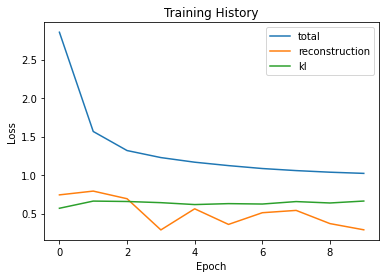

In [13]:
plt.plot(history.history['total_loss'])
plt.plot(history.history['reconstruction_loss'])
plt.plot(history.history['kl_loss'])
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","reconstruction","kl"], loc="upper right")
plt.show()

## Testing

In [14]:
#Draw predictions from test data
results = vae.predict(test_data)

#Transform results back to real variable values
results[:,:num_var_numeric] = scaler.inverse_transform(results[:,:num_var_numeric])
results_df = pd.DataFrame(results)
results_df.columns = model_data_df.columns

#Scale test data numerical values
test_data_results = test_data
test_data_results[:,:num_var_numeric] = scaler.inverse_transform(test_data_results[:,:num_var_numeric])
test_data_df = pd.DataFrame(test_data_results)
test_data_df.columns = model_data_df.columns

In [15]:
results_df

,AGEP,JWMNP,SCHL,PINCP,COW_1.0,COW_2.0,COW_3.0,COW_4.0,COW_5.0,COW_6.0,COW_7.0,COW_8.0
0,38.623753,34.713562,18.851599,50977.792969,17.031776,-14.444029,-11.808594,-0.589261,4.313465,0.356481,-2.577724,0.301634
1,53.119469,12.891928,22.774500,423196.312500,-4.559296,0.774628,-2.671170,-1.273237,-8.133429,0.525219,4.497580,-0.205182
2,50.981037,14.483356,21.366146,483815.875000,7.980847,-7.386105,-9.522441,-0.527168,-0.728912,0.671596,2.015332,-0.561786
3,57.811790,7.427639,17.482843,44531.281250,-15.256879,3.812455,11.819837,1.671790,-5.141950,-6.023818,3.269489,-0.971389
4,64.457085,13.244551,19.446388,66082.531250,-2.638311,-10.208404,-0.133728,8.499305,1.384428,-7.621696,2.173121,-2.286760
...,...,...,...,...,...,...,...,...,...,...,...,...
15237,21.957027,5.744927,17.909145,5961.544434,15.862987,-17.738678,-8.447179,1.713607,7.664814,-2.687781,-2.520704,-0.176556
15238,25.040821,98.369553,13.636961,12298.521484,12.301106,-8.818832,-7.747633,-2.118909,3.159254,0.709189,-2.247351,0.696258
15239,25.744106,28.817045,17.117901,21275.271484,4.729284,-12.262945,-0.767076,4.996216,11.669213,-9.638995,-1.417963,-0.929450
15240,22.734053,13.218945,17.746389,12196.458984,17.376076,-16.877619,-9.957164,0.769833,6.721215,-1.541410,-3.327940,0.048016


In [16]:
test_data_df

,AGEP,JWMNP,SCHL,PINCP,COW_1.0,COW_2.0,COW_3.0,COW_4.0,COW_5.0,COW_6.0,COW_7.0,COW_8.0
0,31.0,30.0,17.0,73000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55.0,10.0,22.0,454900.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,54.0,15.0,21.0,478000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,64.0,10.0,16.0,60000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,65.0,10.0,20.0,83000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
15237,21.0,4.0,19.0,2700.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15238,21.0,90.0,14.0,8200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15239,22.0,35.0,16.0,37200.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
15240,19.0,7.0,18.0,5300.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


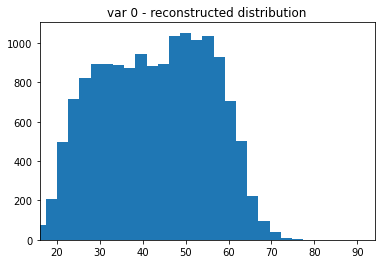

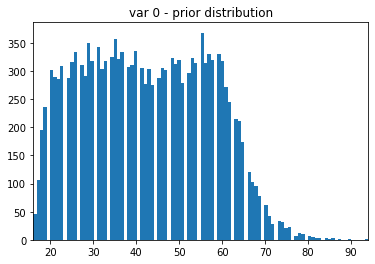

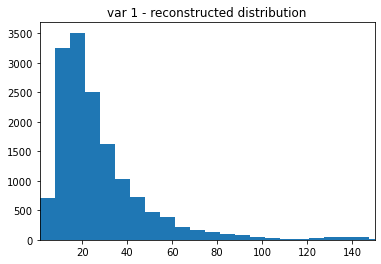

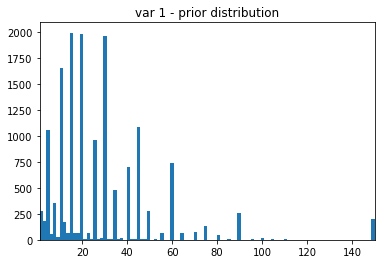

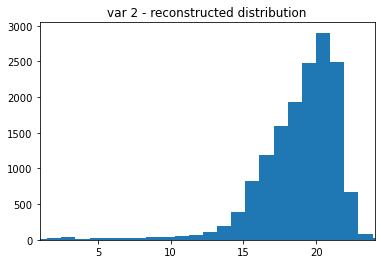

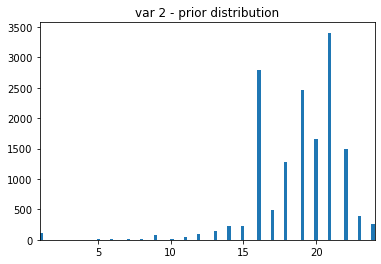

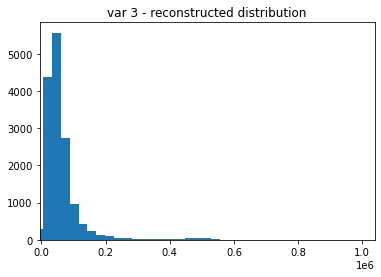

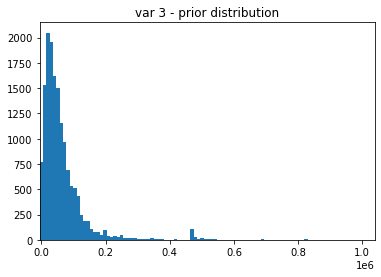

In [19]:
#Show distributions of the resulting variables
for col_idx in range(0,num_var_numeric):
    plt.hist(results[:,col_idx], bins=25)
    plt.xlim(min(test_data_results[:,col_idx]),max(test_data_results[:,col_idx]))
    plt.title(f"var {col_idx} - reconstructed distribution")
    plt.show()
    plt.hist(test_data_results[:,col_idx], bins=100)
    plt.xlim(min(test_data_results[:,col_idx]),max(test_data_results[:,col_idx]))
    plt.title(f"var {col_idx} - prior distribution")
    plt.show()